In [1]:
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import utils
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_excel(r'./dataset.xlsx')
df = df.set_index(df.iloc[:,0].name)

## Random Forest

In [3]:
attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

In [4]:
# Utilizzo i parametri del report

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_split=2, 
                             min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8135525260625501
F1-score [0.88541153 0.5       ]
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      3755
           1       0.74      0.38      0.50      1233

    accuracy                           0.81      4988
   macro avg       0.78      0.67      0.69      4988
weighted avg       0.80      0.81      0.79      4988



In [5]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

[Text(4650.0, 2378.25, 'danceability <= 0.62\ngini = 0.272\nsamples = 7481\nvalue = [6267, 1214]\nclass = No Electronic'),
 Text(2325.0, 1849.75, 'spectral_bandwidth_mean <= 1895.437\ngini = 0.113\nsamples = 5445\nvalue = [5117, 328]\nclass = No Electronic'),
 Text(1162.5, 1321.25, 'chroma_stft_mean <= 0.582\ngini = 0.064\nsamples = 4909\nvalue = [4746, 163]\nclass = No Electronic'),
 Text(581.25, 792.75, 'acousticness <= 0.384\ngini = 0.047\nsamples = 4772\nvalue = [4656, 116]\nclass = No Electronic'),
 Text(290.625, 264.25, '\n  (...)  \n'),
 Text(871.875, 264.25, '\n  (...)  \n'),
 Text(1743.75, 792.75, 'danceability <= 0.398\ngini = 0.451\nsamples = 137\nvalue = [90, 47]\nclass = No Electronic'),
 Text(1453.125, 264.25, '\n  (...)  \n'),
 Text(2034.375, 264.25, '\n  (...)  \n'),
 Text(3487.5, 1321.25, 'acousticness <= 0.112\ngini = 0.426\nsamples = 536\nvalue = [371, 165]\nclass = No Electronic'),
 Text(2906.25, 792.75, 'instrumentalness <= 0.504\ngini = 0.494\nsamples = 264\nvalue

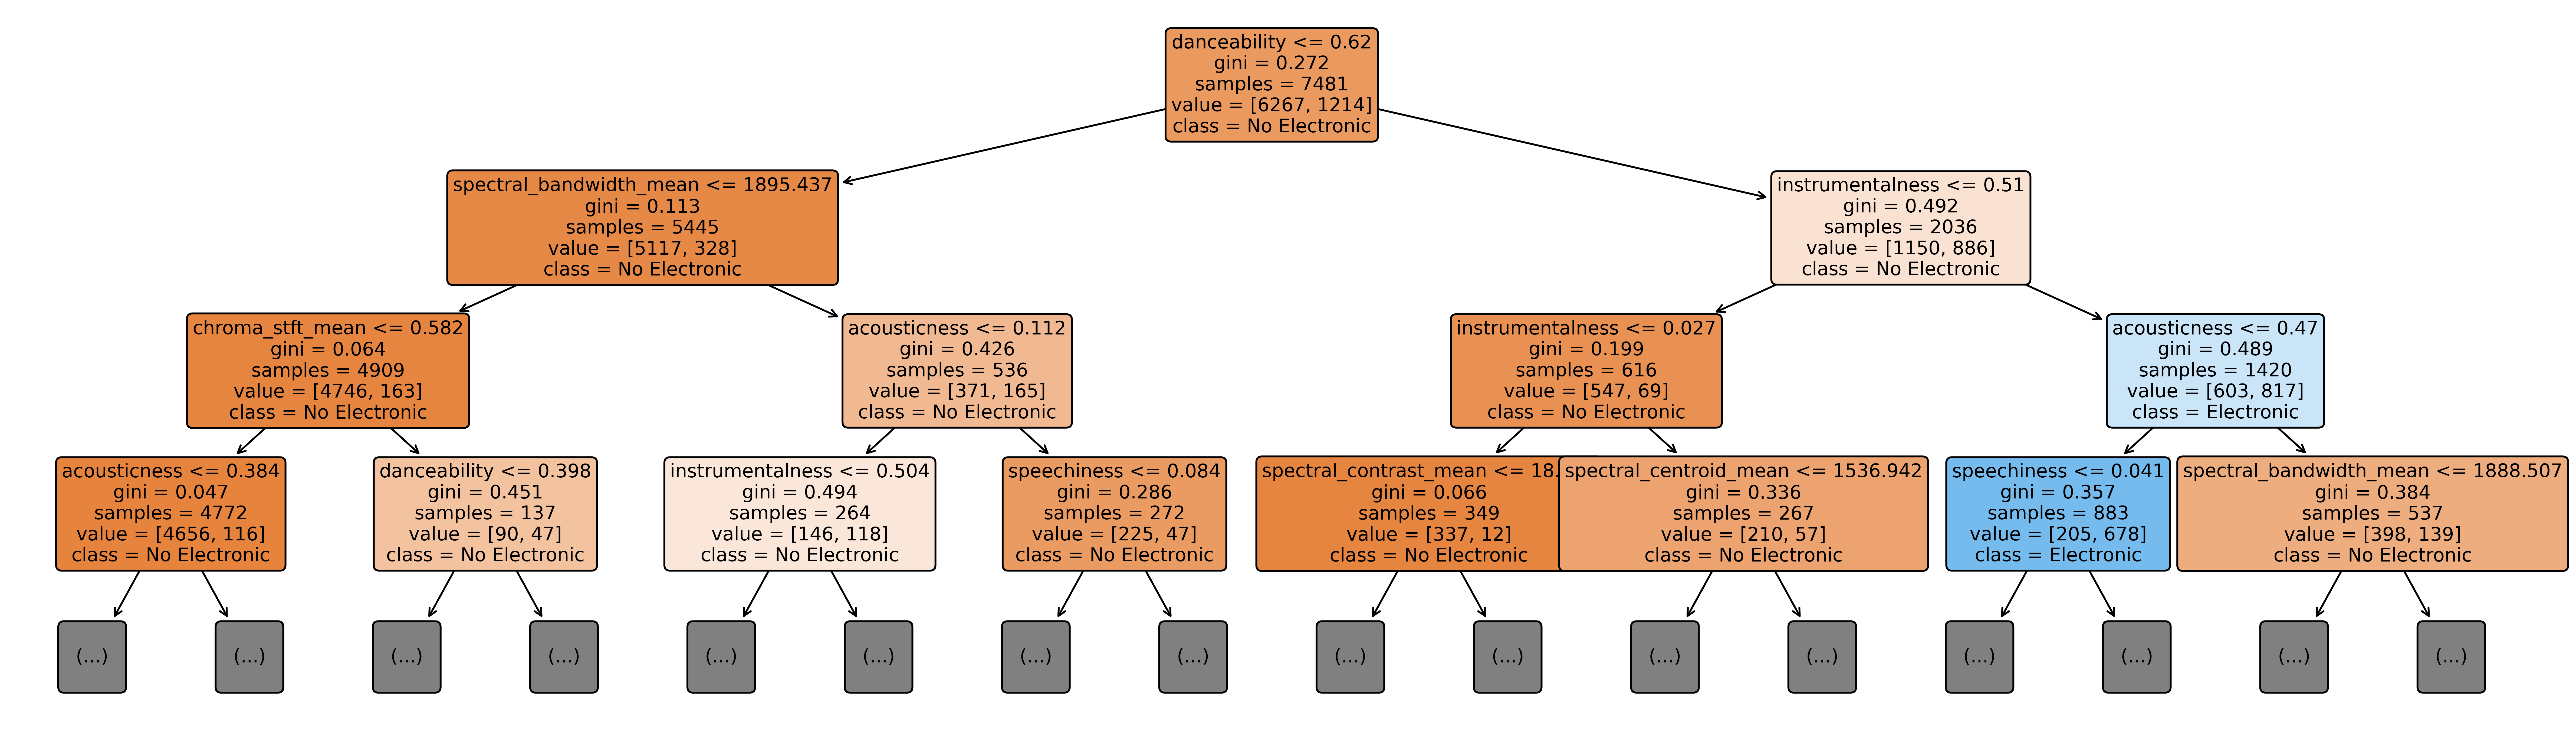

In [6]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (24,7), dpi=500)
sklearn.tree.plot_tree(explainer,feature_names=attributes,
                        class_names=['Electronic' if x == 1 else 'No Electronic' for x in explainer.classes_],  
                        filled=True, rounded=True,
                        label = 'all' , max_depth = 3, fontsize = 10)

In [7]:
# Precisione del global explainer nel descrivere le decisioni della black box
# Fidelity
accuracy_score(y_pred, explainer.predict(X_test))

0.9228147554129912

In [8]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7929029671210907

## Bagging

In [9]:
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

#### Decision Tree

In [10]:
clf = BaggingClassifier(base_estimator=None, n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8019246190858059
F1-score [0.87461929 0.52862595]
              precision    recall  f1-score   support

           0       0.84      0.92      0.87      3755
           1       0.64      0.45      0.53      1233

    accuracy                           0.80      4988
   macro avg       0.74      0.68      0.70      4988
weighted avg       0.79      0.80      0.79      4988



In [11]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [12]:
accuracy_score(y_pred, explainer.predict(X_test))

0.8205693664795509

In [13]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7483961507618284

#### SVM

In [14]:
clf = BaggingClassifier(base_estimator=SVC(C=1000, kernel='rbf', gamma=0.1), n_estimators=20, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.791299117882919
F1-score [0.86492799 0.54120758]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      3755
           1       0.59      0.50      0.54      1233

    accuracy                           0.79      4988
   macro avg       0.72      0.69      0.70      4988
weighted avg       0.78      0.79      0.78      4988



In [15]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [16]:
accuracy_score(y_pred, explainer.predict(X_test))

0.7708500400962309

In [17]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7485966319165999

[Text(4650.0, 2378.25, 'danceability <= 0.692\ngini = 0.366\nsamples = 7481\nvalue = [5679, 1802]\nclass = No Electronic'),
 Text(2325.0, 1849.75, 'spectral_bandwidth_mean <= 1.133\ngini = 0.269\nsamples = 5514\nvalue = [4629, 885]\nclass = No Electronic'),
 Text(1162.5, 1321.25, 'valence <= -1.481\ngini = 0.235\nsamples = 4954\nvalue = [4281, 673]\nclass = No Electronic'),
 Text(581.25, 792.75, 'zcr_mean <= 0.382\ngini = 0.499\nsamples = 93\nvalue = [49, 44]\nclass = No Electronic'),
 Text(290.625, 264.25, '\n  (...)  \n'),
 Text(871.875, 264.25, '\n  (...)  \n'),
 Text(1743.75, 792.75, 'danceability <= -0.202\ngini = 0.225\nsamples = 4861\nvalue = [4232, 629]\nclass = No Electronic'),
 Text(1453.125, 264.25, '\n  (...)  \n'),
 Text(2034.375, 264.25, '\n  (...)  \n'),
 Text(3487.5, 1321.25, 'instrumentalness <= -1.386\ngini = 0.471\nsamples = 560\nvalue = [348, 212]\nclass = No Electronic'),
 Text(2906.25, 792.75, 'danceability <= 0.096\ngini = 0.294\nsamples = 145\nvalue = [119, 26]\

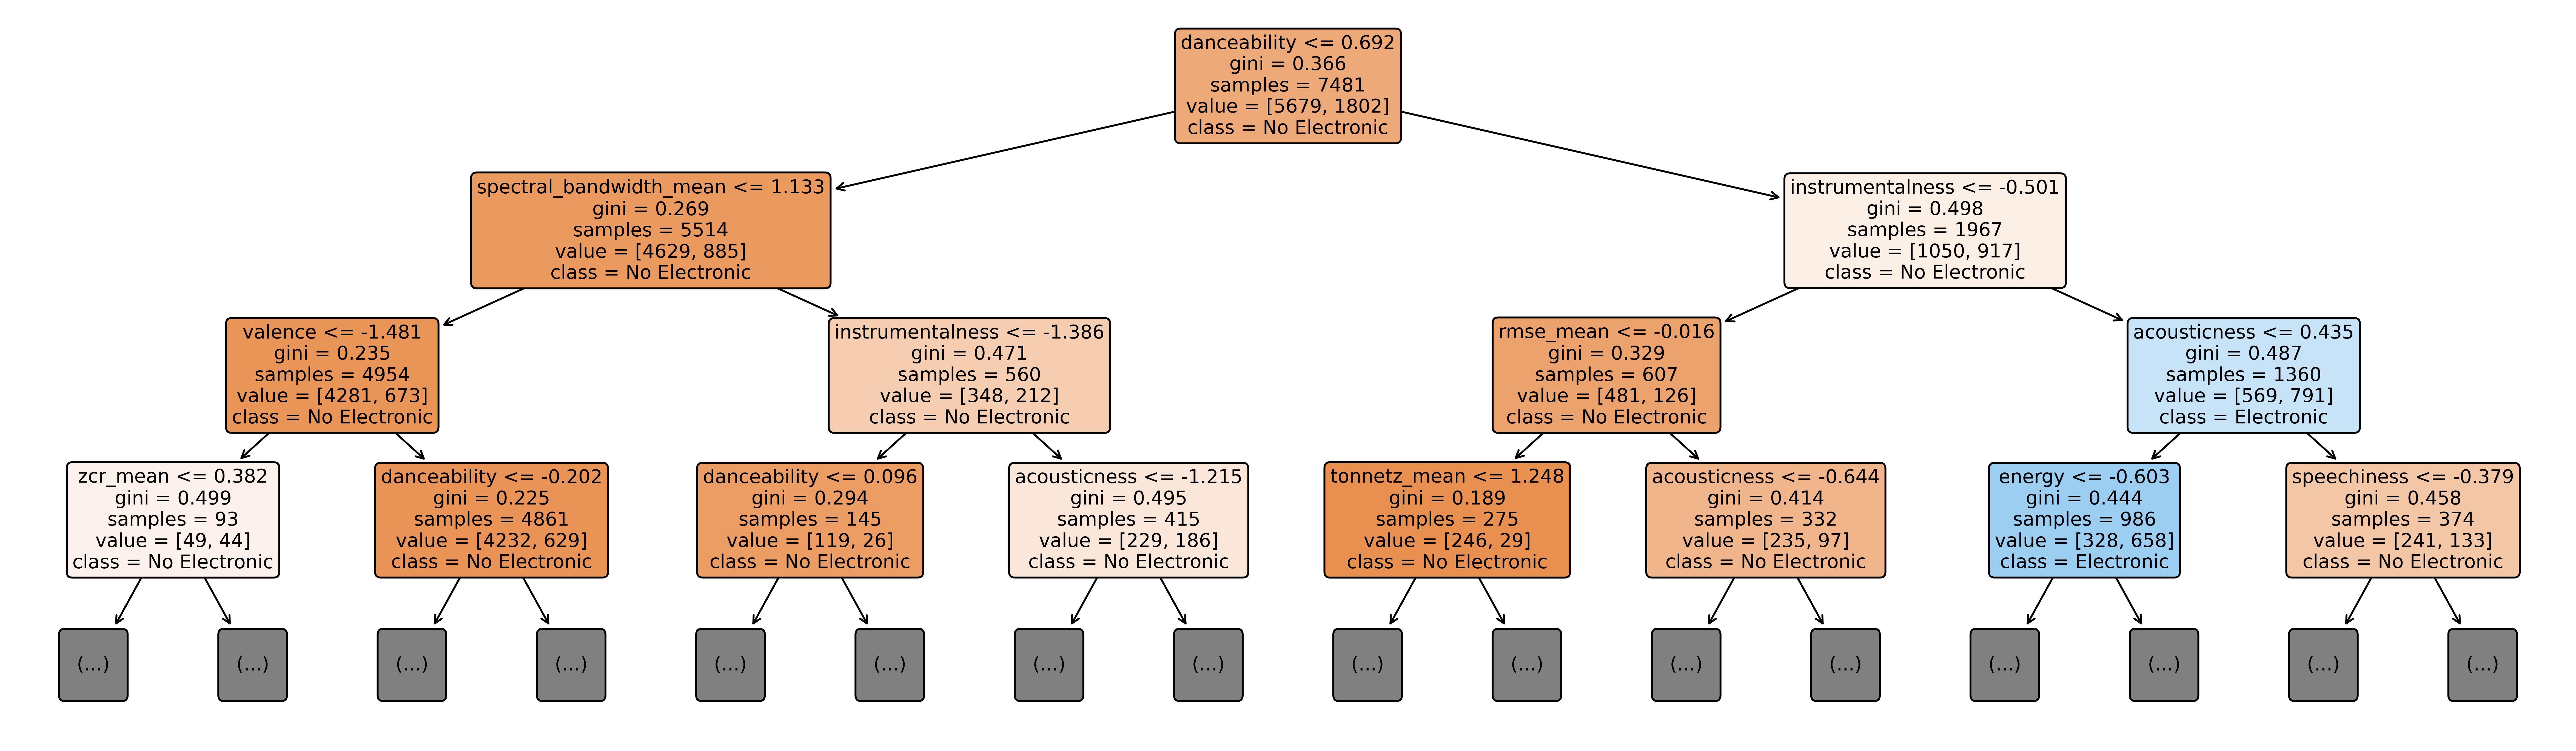

In [18]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (24,7), dpi=500)
sklearn.tree.plot_tree(explainer,feature_names=attributes,
                        class_names=['Electronic' if x == 1 else 'No Electronic' for x in explainer.classes_],  
                        filled=True, rounded=True,
                        label = 'all' , max_depth = 3, fontsize = 10)

#### Random Forest

In [19]:
clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.816158781074579
F1-score [0.88550381 0.53380783]
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      3755
           1       0.72      0.43      0.53      1233

    accuracy                           0.82      4988
   macro avg       0.77      0.69      0.71      4988
weighted avg       0.80      0.82      0.80      4988



In [20]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [21]:
accuracy_score(y_pred, explainer.predict(X_test))

0.8251804330392943

In [22]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7508019246190858

#### KNN

In [23]:
clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=22, weights='distance', metric='minkowski', leaf_size=101), n_estimators=20, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8035284683239775
F1-score [0.8786528  0.48421053]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3755
           1       0.69      0.37      0.48      1233

    accuracy                           0.80      4988
   macro avg       0.76      0.66      0.68      4988
weighted avg       0.79      0.80      0.78      4988



In [24]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [25]:
accuracy_score(y_pred, explainer.predict(X_test))

0.7880914194065758

In [26]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7351643945469126

## Boosting

In [27]:
scaler = preprocessing.StandardScaler()

df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']] = scaler.fit_transform(df[['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'mfcc_mean',
       'chroma_cens_mean', 'chroma_cqt_mean', 'chroma_stft_mean',
       'tonnetz_mean', 'spectral_contrast_mean', 'spectral_centroid_mean',
       'spectral_bandwidth_mean', 'spectral_rolloff_mean', 'rmse_mean',
       'zcr_mean']])

attributes = [col for col in df.columns if col != 'Electronic labeler']
X = df[attributes].values
y = df['Electronic labeler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y)

#### Decision Tree

In [28]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7886928628708901
F1-score [0.86752137 0.47821782]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3755
           1       0.61      0.39      0.48      1233

    accuracy                           0.79      4988
   macro avg       0.72      0.66      0.67      4988
weighted avg       0.77      0.79      0.77      4988



In [29]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [30]:
accuracy_score(y_pred, explainer.predict(X_test))

0.954691259021652

In [31]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.785084202085004

#### Random Forest

In [32]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=20, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8111467522052928
F1-score [0.88263145 0.51692308]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3755
           1       0.70      0.41      0.52      1233

    accuracy                           0.81      4988
   macro avg       0.77      0.68      0.70      4988
weighted avg       0.80      0.81      0.79      4988



In [33]:
y_pred_train = clf.predict(X_train)

explainer = DecisionTreeClassifier()
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier()

In [34]:
accuracy_score(y_pred, explainer.predict(X_test))

0.8135525260625501

In [35]:
#Precisione nel classificare da solo
accuracy_score(y_test, explainer.predict(X_test))

0.7405773857257418